# The Transformation and Accept/Reject (aka. Von Neumann) methods 
Python notebook with exercise on how to generate random numbers following a specific PDF using uniformly distributed random numbers, in this case a third degree polynomial: $f(x) = x^3$, in the interval $[0, C]$ where $C$ is a number that ensures that the function if properly normalized.

Both the Accept-Reject (Von Neumann) and transformation method should be considered for the problem:
- Transformation method (if function can be integrated and then inverted).
- Accept-Reject (or Hit & Miss) method (by Ulam Stanislav and John Von Neumann).

### References:
- G. Cowan: Chapter 3
- P. R. Bevington: page 81-84
- __[40. Monte Carlo Techniques PDG](http://pdg.lbl.gov/2020/reviews/rpp2020-rev-monte-carlo-techniques.pdf)__

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 04-12-2023 (latest update)

***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit import cost
from scipy import stats
plt.rcParams['font.size'] = 18

Set the parameters of the program:

In [2]:
r = np.random
r.seed(42)

save_plots = False  
N_points = 10000    # Number of random points to be generated

## Problem 1: 

#### Produce random points following $f(x) \sim \exp(-x/3), x \in [0, \infty]$.

*Solution example to problem 1*:<br>
Since the range of $x$ is infinite, the only solution is the transformation method. Fortunately, $f(x)$ is simple to normalise (remember that!!!), integrate, and finally invert:
  $$f(x) = 1/3 \exp(-x/3), x \in [0, \infty]$$
  $$F(x) = \int_{-\infty}^x f(x') dx' = [-\exp(-x'/3)]_0^x = -\exp(-x/3) + 1$$
  $$F^{-1}(r) = -3 \ln(1-r)$$

Thus, by generating numbers uniformly, one can get exponentially distributed numbers (with a lifetime of 3) as follows:

In [3]:
# Now produce random numbers using the inverse function found above
x_exp = -3.0*np.log(r.uniform(size=N_points))

And to make sure that we have computed the points correctly, we plot a histogram of the data, and draw the function (here without fitting) on top:

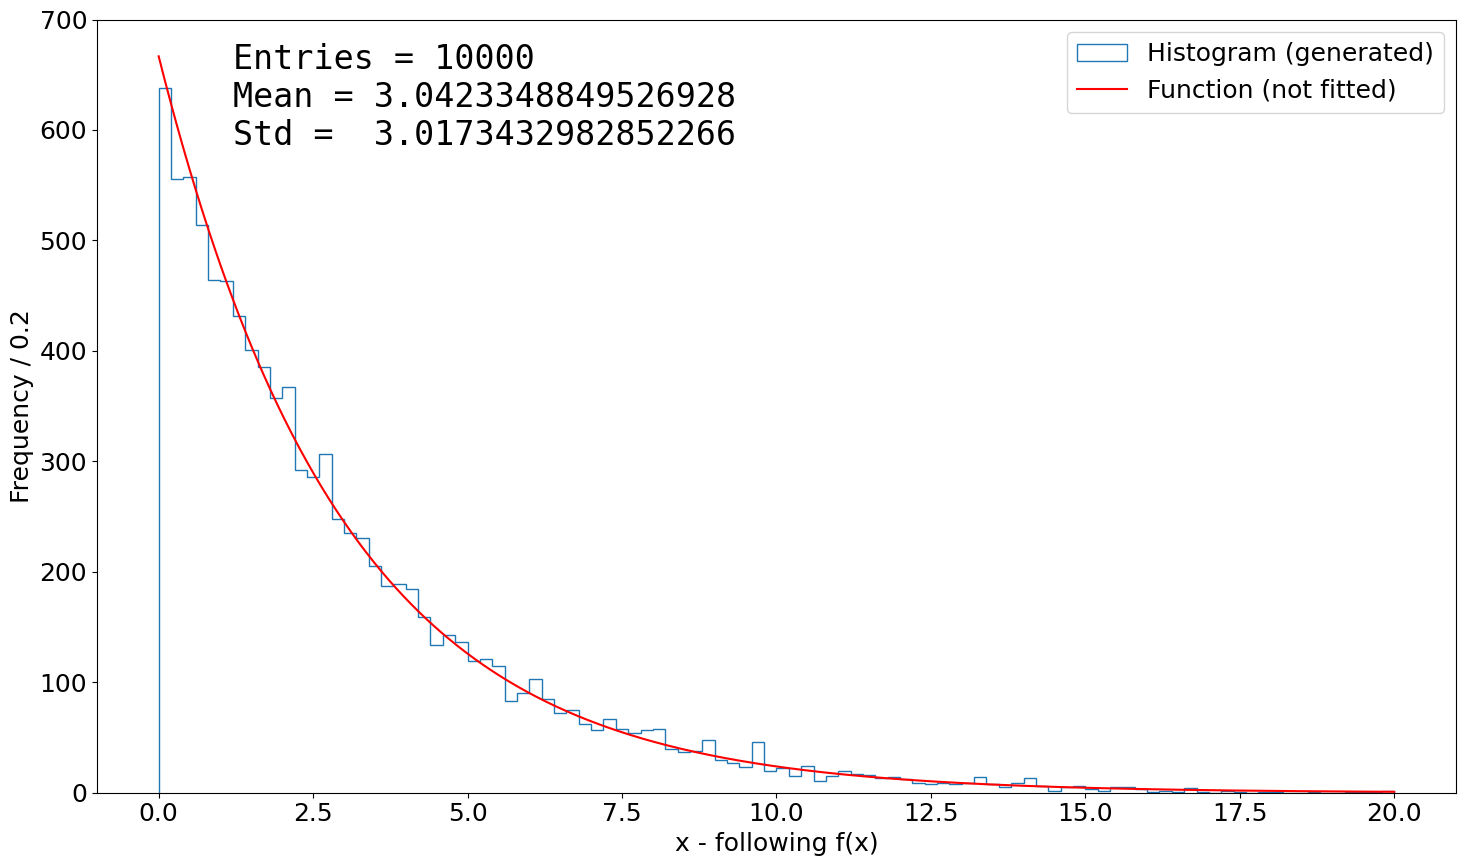

In [8]:
# f(x)
def exp_func(x) :
    # Normalization is N_points * binwidth:
    k = (xmax - xmin) / Nbins          # binwidth
    N = N_points * k                   # Normalization
    return N * 1/3 * np.exp(-x/3)

# Define a reasonable range to plot in:
xmin = 0
xmax = 20
Nbins = 100

fig, ax = plt.subplots(figsize=(15, 9))
ax.hist(x_exp, bins=Nbins, range=(xmin, xmax), histtype='step', label='Histogram (generated)' )
ax.set(xlabel="x - following f(x)", ylabel="Frequency / 0.2", xlim=(xmin-1.0, xmax+1.0))

# Plot f(x)
x_axis1 = np.linspace(xmin, xmax, 1000)
y_axis1 = exp_func(x_axis1)
ax.plot(x_axis1, y_axis1, 'r-', label='Function (not fitted)')

# Define figure text
plot_info = [f'Entries = {len(x_exp)}',
     f'Mean = {x_exp.mean()}',
     f'Std =  {x_exp.std(ddof=1)}']

# Plot figure text


ax.text(0.1, 0.97, "\n".join(plot_info), family='monospace', fontsize=24, verticalalignment='top',transform=ax.transAxes)

# Add legend
ax.legend(loc='best')
fig.tight_layout()

# Save figure
if save_plots: 
    fig.savefig("HistAndFunc_exp.pdf", dpi=600)

## Problem 2: 

#### Produce random points following $g(x) \sim x \cos(x), x \in [0, \frac{\pi}{2}]$.

*Solution Example to Problem 2*:<br>

$g(x)$ can be integrated (through partical integration), but the integral can not be inverted analytically. However, since $g(x)$ is bounded both in $x$ and $y$ the accept/reject method will work. First we define the boundaries, and then we loop until we have enough values generated (a bit annoyingly, there is no do-while loop in Python, which explains the below "funny" `while` construction).

In [9]:
xmin2, xmax2 = 0, np.pi/2         # Note the simple/short notation.
ymin2, ymax2 = 0, 1               # This is not the maximum but a value above the maximum, which is OK though less efficient!

In [10]:
x_cos = np.zeros(N_points)
Ntry = 0
for i in range(N_points):
    while True:
        Ntry += 1
        x2 = r.uniform(xmin2, xmax2)  
        y2 = r.uniform(ymin2, ymax2)        
        if (y2 < x2*np.cos(x2)) :   # If the (x,y)-point fulfills the accept condition...
            break      
    x_cos[i] = x2                   # ...then break and accept the x-value

# Here we continue this until we get N_points under the given function. Note that the total number of points we tried (Ntry) is much bigger

In [11]:
eff = N_points / Ntry                        # Efficiency of generating points (fraction accepted)
eff_error = np.sqrt(eff * (1-eff) / Ntry)    # Error on efficiency (binomial)
integral =  eff * (xmax2-xmin2) * ymax2               # Integral
integral_error = eff_error * (xmax2-xmin2) * ymax2    # Error on integral

print(f"Integral of g(x) = x*cos(x), x in [0, pi/2] is: \t {integral:7.4f} +- {integral_error:6.4f}")
print(f"The efficiency of the accept/reject method is:  \t {eff:.2%} +/- {eff_error:.2%}")
# Since the integral of x*cos in [0,pi/2] is around 0.57, the proper normalisation is 1/0.57

Integral of g(x) = x*cos(x), x in [0, pi/2] is: 	  0.5704 +- 0.0046
The efficiency of the accept/reject method is:  	 36.31% +/- 0.29%


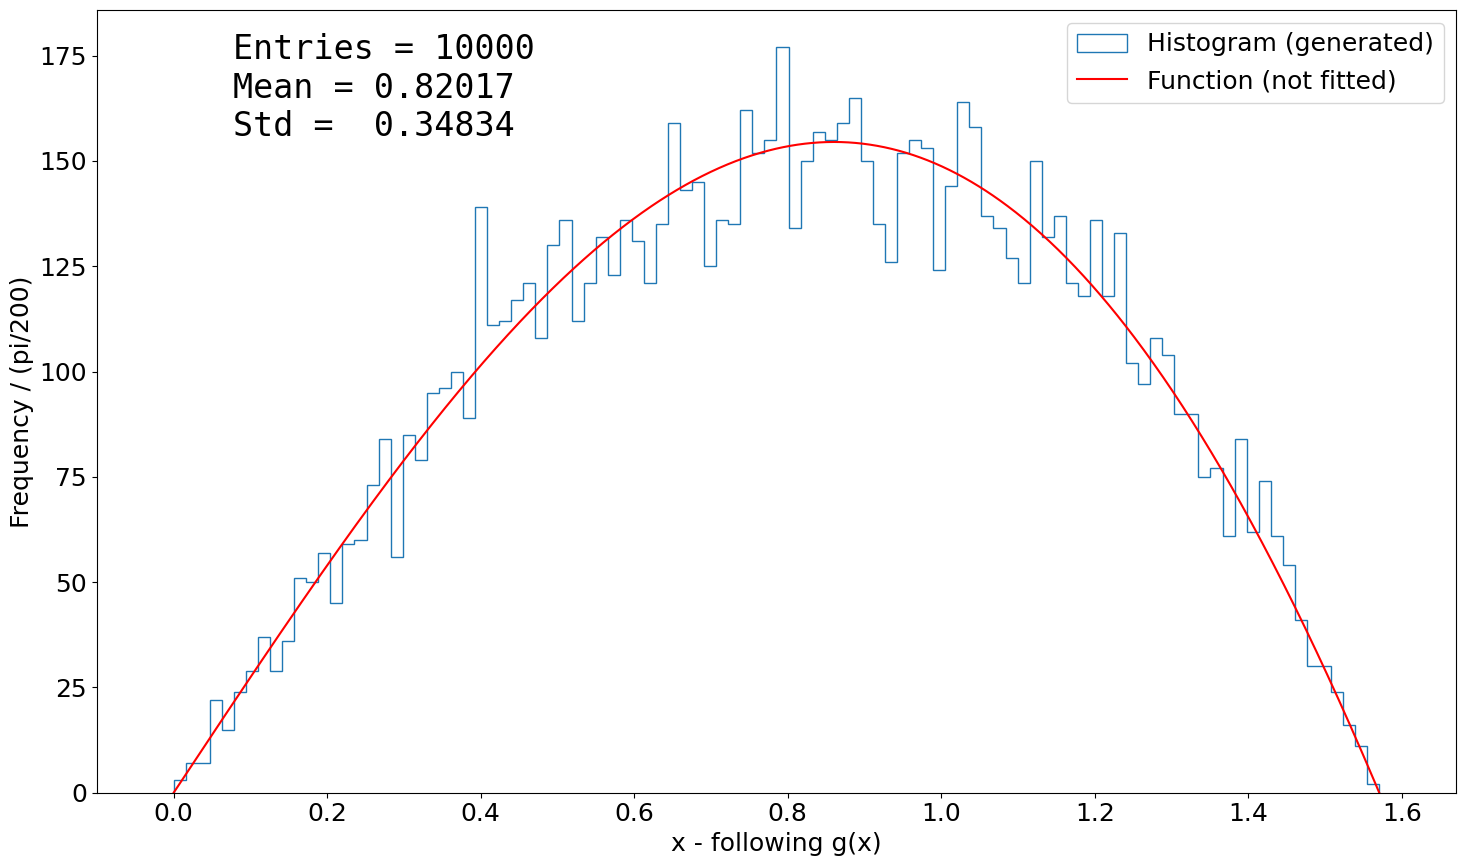

In [16]:
# g(x)
def xcos_func(x) :
    k = (xmax2-xmin2) / Nbins
    N = N_points * k
    return N * 1/integral* x * np.cos(x)     # Normalize the function by adding a factor 1.0/integral

# Plot the values that we got with N_points under the given function
fig2, ax2 = plt.subplots(figsize=(15, 9))
ax2.hist(x_cos, bins=Nbins, range=(xmin2, xmax2), histtype='step', label='Histogram (generated)' )
ax2.set(xlabel="x - following g(x)", ylabel="Frequency / (pi/200)", xlim=(xmin2-0.1, xmax2+0.1))

# Plot g(x)
x_axis2 = np.linspace(xmin2, xmax2, 1000)
y_axis2 = xcos_func(x_axis2)
ax2.plot(x_axis2, y_axis2, 'r-', label='Function (not fitted)')

plot_info = [f'Entries = {len(x_cos)}',
     f'Mean = {x_cos.mean():3.5f}',
     f'Std =  {x_cos.std(ddof=1):3.5f}']

# Plot figure text
ax2.text(0.1, 0.97, "\n".join(plot_info), family='monospace', fontsize=24, verticalalignment='top',transform=ax2.transAxes)

# Add legend
ax2.legend(loc='best')
fig2.tight_layout()

# Save figure
if save_plots: 
    fig2.savefig("HistAndFunc_xcos.pdf", dpi=600)

## Problem 3: 

#### Produce random points following $h(x) \sim \exp(-x/3)\cos(x)^2$ in the interval $[0, \infty]$ and estimate the integral of $h(x)$ in the defined range.

*Solution Example to Problem 3*:<br>

This is a harder problem than the two above. The function can neither be integrated and then inverted nor bounded in $x$. Therefore, one has to combine the two methods. First, we want to generate numbers according to __"a smart box"__, i.e. with a function that covers $h(x)$, i.e. is always greater than $h(x)$ and can be produced using the transformation method. In our case, the exponential function $k(x) = 1/3 \exp(-x/3)$ serves the purpose very well.

We thus draw $x$-values from $k(x)$ (transformation method) and accept the $x$-value if a random value $y$ (chosen between 0 and $k(x)$ falls below the functional value of $h(x)$ at the chosen $x$-value (accept/reject).

In [17]:
N_points = 10000
x_expcos = np.zeros(N_points)
y_expcos = np.zeros(N_points)       # We also save the y-values simply to make an illustrative scatter plot!
Ntry = 0

for i in range(N_points):
    while True:
        Ntry += 1
        x3 = -3.0*np.log(r.uniform(size=1))      # Expression for exponentially distributed numbers from Problem 1
        y3 = r.uniform(0, np.exp(-x3/3))         # The x and y limits for the smart box are given by the function
        if (y3 < np.exp(-x3/3)*np.cos(x3)**2) :  # If the (x,y)-point fulfills the accept condition...
            break
            
    x_expcos[i] = x3                             # ...then break and accept the x-value
    y_expcos[i] = y3
    
# Again, we continue this until we get N_points under the given function.

/tmp/ipykernel_170296/1203246912.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_expcos[i] = x3                             # ...then break and accept the x-value
/tmp/ipykernel_170296/1203246912.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_expcos[i] = y3


In [18]:
f  = N_points / Ntry
ef = np.sqrt(f * (1.0-f) / Ntry)

integral3  = 3.0 * f       # Multiply integral of exponential (k(x)) with fraction
eintegral3 = 3.0 * ef      # Same for error

print(f"Integral of h(x) = exp(-x/3)*cos(x)^2, x in [0,inf] is:  \t {integral3:7.4f} +- {eintegral3:6.4f}")
print(f"The efficiency of the accept/reject method used here is: \t {f:.2%} +/- {ef:.2%}")

Integral of h(x) = exp(-x/3)*cos(x)^2, x in [0,inf] is:  	  1.5330 +- 0.0107
The efficiency of the accept/reject method used here is: 	 51.10% +/- 0.36%


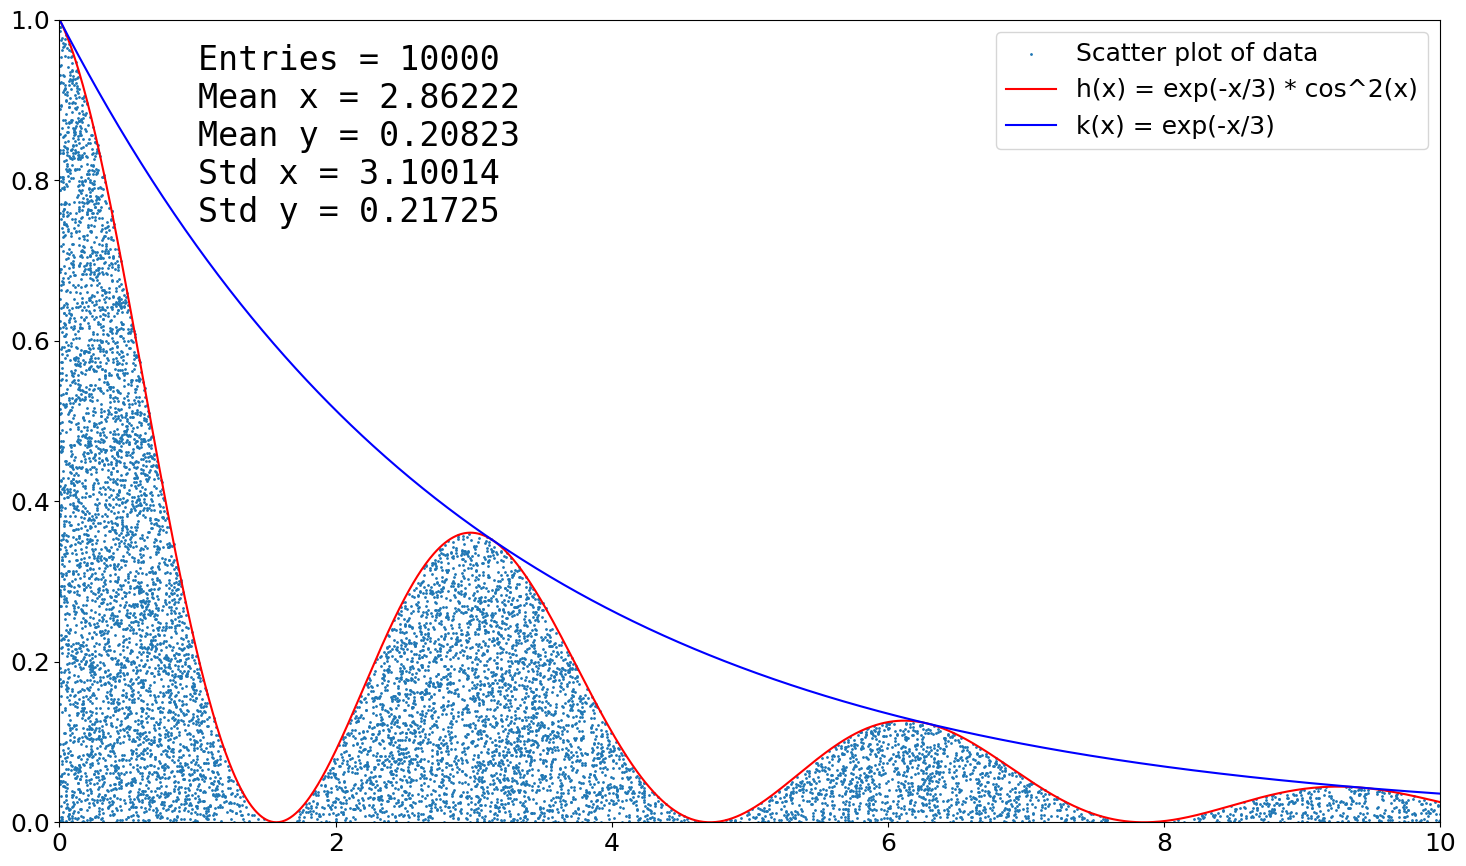

In [20]:
# Distribution of (x,y) points (for illustration) with h(x) and k(x) on top:
fig3, ax3 = plt.subplots(figsize=(15, 9))
ax3.scatter(x_expcos, y_expcos, s=1, label='Scatter plot of data')
ax3.set(xlim=(0, 10), ylim=(0, 1))

# h(x)
def expcos_func(x):
    return np.exp(-x/3)*np.cos(x)**2

# Plot h(x)
x_axis3 = np.linspace(0, 10, 1000)
y_axis3 = expcos_func(x_axis3)
ax3.plot(x_axis3, y_axis3,'r-', label='h(x) = exp(-x/3) * cos^2(x)')

# k(x)
def exp_func(x):
    return np.exp(-x/3)

# Plot k(x)
x_axis4 = np.linspace(0, 10, 1000)
y_axis4 = exp_func(x_axis4)
ax3.plot(x_axis4, y_axis4, color='b', label='k(x) = exp(-x/3)')

# Make figure text
plot_info = [f'Entries = {len(x_expcos)}',
      f'Mean x = {x_expcos.mean():3.5f}',
      f'Mean y = {y_expcos.mean():3.5f}',
      f'Std x = {x_expcos.std(ddof=1):3.5f}',
      f'Std y = {y_expcos.std(ddof=1):3.5f}',
]

# Add figure text
ax3.text(0.1, 0.97, "\n".join(plot_info), family='monospace', fontsize=24, verticalalignment='top',transform=ax3.transAxes)

# Add legend
ax3.legend(loc='best')
fig3.tight_layout()

# Save plot
if save_plots: 
    fig3.savefig("HistAndFunc_expcos.pdf", dpi=600)